In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import sys
import os
from scipy.optimize import newton, minimize, fsolve
from scipy.interpolate import InterpolatedUnivariateSpline, krogh_interpolate, PchipInterpolator, interp1d
import numpy as np
import copy
import re
from pathlib import Path

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
%matplotlib inline

In [2]:
# Worklist:

# Objective:
# Program to process files in batches using common settings.
# Should read all the .tab files in a folder.
# Apply trend correction and calculate surrogate count.
# Plot and save proliferation rate as a function of time.
# Calculate proliferation rate and save to excel file.

# Settings:
# trend_corr [float] = trend correction
# min_count [int] = minimum number of [cells, conf] when calculating growth rate
# max_count [int] = maximum number of [cells, conf] when calculating growth rate
# min_conf [int] = minimum number of [cells, conf] when calculating growth rate
# max_conf [int] = maximum number of [cells, conf] when calculating growth rate
# min_elapsed [int] = minimum elapsed time before calculating growth rate
# metric [count, conf, sur_count] = what metric should be used to calculate growth rate
# sur_count_training_files [string] = specify which files to use to train the conf to surrugate count conversion
# sur_count_training_conc [float] = 


# Save proliferation to file.
# Plot proliferation rate as a function of drug concentration
#     - Calculate the ED50 and superimpose on plot

# Plot proliferation rate as a function of time.


In [3]:
def loss_func_c1(t, y):
    return((np.abs(y - t) / t) * 100)
def loss_func_l1(t, y):
    return(np.abs(y - t))  # l1
def loss_func_l2(t, y):
    return((y - t)**2)     # l2

def lin_fit(x, alpha, beta):
    return(alpha + x*beta)

def obj_lin_fit(loss_func, t, x, p):
    alpha = p[0]
    beta = p[1]
    y = lin_fit(x, alpha, beta)
    loss = sum(loss_func(t, y))
    return(loss)

def t4fourier_fit(x, p):
    # Period length in conf
    # Should be a little more than 100
    # to allow smooth transition between periods.
    period_len = 150 # a little more than 
    return(p[0] + p[1]*np.sin(x/period_len) + p[2]*np.sin(2*x/period_len) + p[3]*np.sin(3*x/period_len) + p[4]*np.sin(4*x/period_len) + p[5]*np.cos(x/period_len) + p[6]*np.cos(2*x/period_len) + p[7]*np.cos(3*x/period_len) + p[8]*np.cos(4*x/period_len))

def obj_t4fourier_fit(loss_func, t, x, p):
    y = t4fourier_fit(x, p)
    loss = sum(loss_func(t, y))
    return(loss)

In [4]:
def trend_corr_fun(well_df, image_metric_val, elapsed, cn):
    ###################
    # Use 5 points to estimate exponential growth rate of the given metric.
    # Assess whether the midpoint deviates more than "trend_corr" from the fitted curve.
    # If yes, replace with value predited by the fitted curve, otherwise do nothing.
    # Edge cases:
    # Still fit 5 points but the assessment is no longer made to the midpoint.

    image_metric_val_corr = list()  # Store the new values
    # Edge case of the first point:
    i = 0
    bnds = ((0, None), (None, None))
    def fun_lin(p): return(obj_lin_fit(loss_func_l2, image_metric_val[i:i+5], elapsed[i:i+5], p))
    p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
    pred = lin_fit(elapsed[i], p_lin.x[0], p_lin.x[1])
    if abs(pred - image_metric_val[i]) / image_metric_val[i] > trend_corr:
        image_metric_val_corr.append(pred)
    else:
        image_metric_val_corr.append(image_metric_val[i])

    # Edge case of the second first point:
    i = 1
    bnds = ((0, None), (None, None))
    def fun_lin(p): return(obj_lin_fit(loss_func_l2, image_metric_val[i-1:i+4], elapsed[i-1:i+4], p))
    p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
    pred = lin_fit(elapsed[i], p_lin.x[0], p_lin.x[1])
    if abs(pred - image_metric_val[i]) / image_metric_val[i] > trend_corr:
        image_metric_val_corr.append(pred)
    else:
        image_metric_val_corr.append(image_metric_val[i])

    # Cases where the midpoint is compared to the fitted curve:
    for i in range(2, len(image_metric_val)-2):
        bnds = ((0, None), (None, None))
        def fun_lin(p): return(obj_lin_fit(loss_func_l2, image_metric_val[i-2:i+3], elapsed[i-2:i+3], p))
        p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
        pred = lin_fit(elapsed[i], p_lin.x[0], p_lin.x[1])
        if abs(pred - image_metric_val[i]) / image_metric_val[i] > trend_corr:
            image_metric_val_corr.append(pred)
        else:
            image_metric_val_corr.append(image_metric_val[i])

    # Edge case of the second last point:
    i = len(image_metric_val)-2
    bnds = ((0, None), (None, None))
    def fun_lin(p): return(obj_lin_fit(loss_func_l2, image_metric_val[i-3:i+2], elapsed[i-3:i+2], p))
    p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
    pred = lin_fit(elapsed[i], p_lin.x[0], p_lin.x[1])
    if abs(pred - image_metric_val[i]) / image_metric_val[i] > trend_corr:
        image_metric_val_corr.append(pred)
    else:
        image_metric_val_corr.append(image_metric_val[i])

    # Edge case of the last point:
    i = len(image_metric_val)-1
    bnds = ((0, None), (None, None))
    def fun_lin(p): return(obj_lin_fit(loss_func_l2, image_metric_val[i-4:i+1], elapsed[i-4:i+1], p))
    p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
    pred = lin_fit(elapsed[i], p_lin.x[0], p_lin.x[1])
    if abs(pred - image_metric_val[i]) / image_metric_val[i] > trend_corr:
        image_metric_val_corr.append(pred)
    else:
        image_metric_val_corr.append(image_metric_val[i])

    # Overwrite the original values (also convert back from log space):
    well_df[cn] = [2**v for v in image_metric_val_corr]
    ###################
    
    return(well_df)

In [5]:
def calc_doublings_per_day(df, metric, min_metric, max_metric, max_dpd=True, max_dpd_reads=6):
    ### Calculate doublings per day (unit: 1/d) from growth data ###
    mm_mask = (df[metric].values > min_metric) & (df[metric].values < max_metric)
    df_trim = df.loc[mm_mask, :]
    
    x = df_trim['Elapsed'].values
    t = np.log2(df_trim[metric].values)
    if max_dpd is False and len(t) > 1:
        bnds = ((0, None), (0, None))
        def fun_lin(p): return(obj_lin_fit(loss_func_l2, t, x, p))
        p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
        dpd = p_lin.x[1]*24
        return(dpd)
    elif max_dpd is True and len(t) >= max_dpd_reads:
        dpd_max = 0
        for i in range(len(t) - max_dpd_reads + 1):
            t_slice = t[i:i+max_dpd_reads]
            x_slice = x[i:i+max_dpd_reads]
            bnds = ((0, None), (0, None))
            def fun_lin(p): return(obj_lin_fit(loss_func_l2, t_slice, x_slice, p))
            p_lin = minimize(fun_lin, (1, 1), method='L-BFGS-B', bounds=bnds)
            ### This is pretty heuristic, enforced max loss of the objective function:
            if p_lin.fun < (max_dpd_reads*0.16):
                dpd = p_lin.x[1]*24
                if dpd > dpd_max:
                    dpd_max = dpd
        return(dpd_max)
    else:
        return(0)

In [6]:
def read_data(data_folder, trend_corr, min_elapsed, verbose=True):
    ### Read .tab file data in specified data folder ###
    p = Path(data_folder)
    filenames = list(map(str, p.glob('*.tab')))
    data_dict = dict()
    if verbose:
        print('Reading files...')
    for fnam in filenames:
        ### Parse filename information ###
        date, single_agent, gradient_agent, metric = fnam.split('/')[-1][0:-4].split('_')
        gradient_agent = gradient_agent[0:-9]
        if verbose:
            print('From path: {}\nParsed date: {}, single agent: {}, gradient agent: {}, metric: {}'.format(fnam, date, single_agent, gradient_agent, metric))

        ### Make nested dictionary data structure ###
        # 1. Gradient agent
        # 2. Single agent
        # 3. Date/version (must be unique)
        # 4. Metric
        if gradient_agent not in data_dict:
            data_dict[gradient_agent] = dict()
        if single_agent not in data_dict[gradient_agent]:
            data_dict[gradient_agent][single_agent] = dict()
        if date not in data_dict[gradient_agent][single_agent]:
            data_dict[gradient_agent][single_agent][date] = dict()
        if metric in data_dict[gradient_agent][single_agent]:
            raise Exception('Duplicate experiment. From path: {}\nParsed date: {}, single agent: {}, gradient agent: {}, metric: {}'.format(fnam, date, single_agent, gradient_agent, metric))
        else:
            data_dict[gradient_agent][single_agent][date][metric] = dict()
        # Pointer to nested dict:
        dict_cur = data_dict[gradient_agent][single_agent][date][metric]

        ### Read datafile ###
        # First line contains the vessel name:
        with open(fnam) as fh:
            first_line = fh.readline()
        vessel_name_val = first_line.split(':')[-1]
        vessel_name_val = vessel_name_val.strip()
        dict_cur['vessel_name'] = vessel_name_val

        # Read rest as tab separated file:    
        df_raw = pd.read_csv(fnam, sep='\t', skiprows=1)
        # Apply minimum elapsed time:
        elapsed_mask = df_raw['Elapsed'] >= min_elapsed
        df_raw = df_raw.loc[elapsed_mask, :]
        # Move date/time out of the data matrix:
        dict_cur['Date Time'] = df_raw['Date Time'].values
        df_raw = df_raw.drop(['Date Time'], axis=1)
        df_raw = df_raw.set_index('Elapsed')
        # Save raw data:
        dict_cur['raw_data'] = df_raw

        ### Split data into one dataframe per well ###
        dict_cur['single_well_data'] = dict()
        colnames = df_raw.columns
        well2gradient_conc = dict()
        well2rep = dict()
        well2average = dict()
        gradient_conc_counter = dict()
        # Read drug concentration from column name:
        for cn in colnames:
            name_string = cn.split(',')[0]
            # Well name (letter:number):
            well = re.search('\([A-H][0-9]{1,2}\)', name_string).group(0)[1:-1]
            # Finding the concentration:
            c_start = name_string.index(gradient_agent) + len(gradient_agent) + 1
            c_end = name_string.index('({})'.format(well)) - 1
            drug_conc_string = name_string[c_start:c_end]
            drug_conc = re.search('([\d\.]+)', drug_conc_string).group(0)
            well2gradient_conc[well] = drug_conc
        if verbose:
            print('Concentration gradient: {}'.format(', '.join(sorted(list(set(well2gradient_conc.values()))))))

        # Use the well name to isolate all image columns
        # from this well into one dataframe:
        for well, drug_conc in well2gradient_conc.items():
            # Count replicates:
            if drug_conc not in gradient_conc_counter:
                gradient_conc_counter[drug_conc] = 1
            else:
                gradient_conc_counter[drug_conc] += 1
            well2rep[well] = gradient_conc_counter[drug_conc]

            # Extract dataframe for each well:
            well_p = '({})'.format(well)
            well_df = df_raw.filter(regex=well_p)
            # Iterate over each image of the well:
            colnames = well_df.columns
            for cn in colnames:
                image_metric_val = np.log2(well_df[cn].values)
                elapsed = well_df.index.values

                ### Correction for sporadic out of focus problems ###
                if trend_corr > 0:
                    well_df = trend_corr_fun(well_df, image_metric_val, elapsed, cn)

            dict_cur['single_well_data'][well] = dict()
            dict_cur['single_well_data'][well]['all_images'] = well_df
            dict_cur['single_well_data'][well]['average'] = well_df.mean(axis=1)
            # Save average values:
            well2average[well] = well_df.mean(axis=1).values

        # Extract the well averages:
        avg_df = pd.DataFrame.from_dict(well2average)
        avg_df['Elapsed'] = df_raw.index.values
        # Melt data into: Elapsed, well, value (count/conf)
        avg_df_melt = pd.melt(avg_df, id_vars=['Elapsed'], value_name=metric, var_name='well')
        # Add the gradient agent concentration as a column:
        avg_df_melt['conc'] = [float(well2gradient_conc[w]) for w in avg_df_melt['well'].values]
        # Add the replicate as a column:
        avg_df_melt['rep'] = [well2rep[w] for w in avg_df_melt['well'].values]
        dict_cur['well_average'] = avg_df_melt

    return(data_dict)

In [7]:
def add_sur_count_metric(data_dict, data_folder, sur_count_training_files, sur_count_training_conc, max_elapsed=100, sur_count_force_fit_method=None, rolling_window=30, verbose=True):
    ### Make a conversion between confluency and count (surrogate count), ###
    ### then add this to the data_dict as a new metric. ###
    # Collect count per conf from specified input files:
    df_list = list()
    for tr_file in sur_count_training_files:
        try:
            date, single_agent, gradient_agent = tr_file.split('_')
        except Exception:
            print(tr_file)
            assert(False)        
        elapsed_mask = data_dict[gradient_agent][single_agent][date]['count']['well_average']['Elapsed'] <= max_elapsed
        df_melt_count = data_dict[gradient_agent][single_agent][date]['count']['well_average'].loc[elapsed_mask].copy()
        df_melt_conf = data_dict[gradient_agent][single_agent][date]['conf']['well_average'].loc[elapsed_mask].copy()
        conc_mask = df_melt_count['conc'].isin(sur_count_training_conc).values
        df_melt_count = df_melt_count.loc[conc_mask, :]
        df_melt_conf = df_melt_conf.loc[conc_mask, :]
        df_melt_conf['count_per_conf'] = df_melt_count['count'].values / df_melt_conf['conf'].values
        df_list.append(df_melt_conf)
    df_all = pd.concat(df_list)

    ### Solution using smoothening and linear spline ###
    # Window size 20, with added Gaussian noise: 20 standard deviations #
    df_all = df_all.sort_values(by=['conf'])
    plot_x = np.arange(min(df_all['conf'].values), max(df_all['conf'].values), 0.01)
    xy_smooth = df_all.loc[:, ['conf', 'count_per_conf']].rolling(rolling_window, win_type='gaussian').mean(std=rolling_window).dropna()
    xy_smooth = xy_smooth.sort_values(by=['conf'])
    # k=1 means linear:
    lin_spline = InterpolatedUnivariateSpline(xy_smooth['conf'].values, xy_smooth['count_per_conf'].values, k=1)
    def lin_spline_fun(x_arr):
        xt = list()
        for x in x_arr:
            if x < min(plot_x):
                xt.append(lin_spline(min(plot_x)))
            elif x > max(plot_x):
                xt.append(lin_spline(max(plot_x)))
            else:
                xt.append(lin_spline(x))
        return(np.array(xt))
    # Calculate l1 loss:
    lin_spline_loss = sum(loss_func_l1(df_all['count_per_conf'].values, lin_spline_fun(df_all['conf'].values)))

    ### Solution fitting a 4 term Fourier series using least square minimization ###
    def fun_t4fourier(p): return(obj_t4fourier_fit(loss_func_l2, df_all['count_per_conf'].values, df_all['conf'].values, p))
    p_t4fourier = minimize(fun_t4fourier, (0, 0, 0, 0, 0, 0, 0, 0, 0), method='BFGS')
    def t4fourier(x_arr):
        xt = list()
        for x in x_arr:
            if x < min(plot_x):
                xt.append(t4fourier_fit(min(plot_x), p_t4fourier.x))
            elif x > max(plot_x):
                xt.append(t4fourier_fit(max(plot_x), p_t4fourier.x))
            else:
                xt.append(t4fourier_fit(x, p_t4fourier.x))
        return(np.array(xt))
    # Calculate l1 loss:
    t4fourier_loss = sum(loss_func_l1(df_all['count_per_conf'].values, t4fourier(df_all['conf'].values)))

    ### Choose a method based on l1 loss ###
    if sur_count_force_fit_method is not None:
        if sur_count_force_fit_method.lower() == 'fourier':
            fit_method_str = 'fourier'
            fit_method = t4fourier
        elif sur_count_force_fit_method.lower() == 'spline':
            fit_method_str = 'spline'
            fit_method = lin_spline_fun
        else:
            raise Exception('Did not understand input sur_count_force_fit_method = {}'.format(sur_count_force_fit_method))
    else:
        if t4fourier_loss <= lin_spline_loss:
            if verbose:
                print('Chose fourier over spline, l1 loss: {:.1f} < {:.1f}'.format(t4fourier_loss, lin_spline_loss))
            fit_method_str = 'fourier'
            fit_method = t4fourier
        else:
            if verbose:
                print('Chose spline fourier, l1 loss: {:.1f} < {:.1f}'.format(lin_spline_loss, t4fourier_loss))
            fit_method_str = 'spline'
            fit_method = lin_spline_fun

    ### Plot results ###
#    plot_x = np.arange(min(df_all['conf'].values), max(df_all['conf'].values), 0.01)
    plt.figure(figsize=(10, 8))
    fig = sns.scatterplot(x="conf", y='count_per_conf', hue='conc', data=df_all)
    if fit_method_str == 'spline':
        fig.plot(plot_x, lin_spline_fun(plot_x), label='Spline fit (chosen)');
        fig.plot(plot_x, t4fourier(plot_x), label='Fourier fit');
    else:
        fig.plot(plot_x, lin_spline_fun(plot_x), label='Spline fit');
        fig.plot(plot_x, t4fourier(plot_x), label='Fourier fit (chosen)');
    plt.title('Confluency to count conversion fit', size=20)
    plt.ylabel('Count per confluency percentage')
    plt.xlabel('Confluency percentage')
    plt.legend(loc="upper center");
    plt.savefig('{}/conf_to_count.pdf'.format(data_folder))
    if verbose:
        plt.show()
    plt.close()
    
    ### Convert confluency to surogate count ###
    for gradient_agent in data_dict.keys():
        for single_agent in data_dict[gradient_agent].keys():
            for date in data_dict[gradient_agent][single_agent].keys():
                dict_cur = data_dict[gradient_agent][single_agent][date]
                dict_cur['sur_count'] = dict()
                dict_cur['sur_count']['vessel_name'] = dict_cur['conf']['vessel_name']
                # Copy the confluency data:
                dict_cur['sur_count']['well_average'] = dict_cur['conf']['well_average'].copy()
                # Add the surogate count as column:
                dict_cur['sur_count']['well_average']['sur_count'] = dict_cur['sur_count']['well_average']['conf'].values * fit_method(dict_cur['sur_count']['well_average']['conf'].values)
                # Remove the conf column:
                dict_cur['sur_count']['well_average'] = dict_cur['sur_count']['well_average'].drop(['conf'], axis=1)

    return(data_dict)

In [8]:
def dpd_tidy_df(data_dict, data_folder, min_count, max_count, min_conf, max_conf, verbose=True):
    ### Calculate proliferation rate and return as tidy dataframe ###
    tidy_df_list = list()
    for gradient_agent in data_dict.keys():
        for single_agent in data_dict[gradient_agent].keys():
            for date in data_dict[gradient_agent][single_agent].keys():
                # Safety chech that the vessel names are the same:
                metric1 = list(data_dict[gradient_agent][single_agent][date].keys())[0]
                vessel_name = data_dict[gradient_agent][single_agent][date][metric1]['vessel_name']
                # Plot dpd for all metrics into the same pdf:
                plot_name = '{}/{}_{}_{}-gradient_dpd-barplots.pdf'.format(data_folder, date, single_agent, gradient_agent)
                pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)
                for metric in data_dict[gradient_agent][single_agent][date].keys():
                    dict_cur = data_dict[gradient_agent][single_agent][date][metric]
                    assert(dict_cur['vessel_name'] == vessel_name)
                    well_list = sorted(list(set(dict_cur['well_average']['well'].values)))
                    # Generate tidy dataframe from dict:
                    df_dict = dict()
                    df_dict['well'] = list()
                    df_dict['conc'] = list()
                    df_dict['rep'] = list()
                    df_dict['dpd'] = list()
                    for well in well_list:
                        well_mask =  dict_cur['well_average']['well'].values == well
                        well_df = dict_cur['well_average'].loc[well_mask, :]
                        if metric == 'conf':
                            dpd = calc_doublings_per_day(well_df, metric, min_conf, max_conf)
                        else:
                            dpd = calc_doublings_per_day(well_df, metric, min_count, max_count)
                        df_dict['well'].append(well)
                        df_dict['conc'].append(well_df['conc'].values[0])
                        df_dict['rep'].append(well_df['rep'].values[0])
                        df_dict['dpd'].append(dpd)
                    dict_cur['doublings_per_day'] = pd.DataFrame.from_dict(df_dict)

                    # Add columns for tidy dataframe:
                    dict_cur['doublings_per_day']['gradient_agent'] = gradient_agent
                    dict_cur['doublings_per_day']['single_agent'] = single_agent
                    dict_cur['doublings_per_day']['date'] = date
                    dict_cur['doublings_per_day']['metric'] = metric
                    tidy_df_list.append(dict_cur['doublings_per_day'].copy())

                    # Write barplots of dpd:
                    fig = plt.figure(figsize=(10, 8))
                    sns_fig = sns.barplot(x="conc", y='dpd', data=dict_cur['doublings_per_day'])
                    plt.title('Doublings per day, metric: {}'.format(metric), size=20)
                    plt.ylabel('Doublings per day')
                    plt.xlabel('{} concentration'.format(gradient_agent))
                    pdf_plot.savefig(fig)
                    if verbose:
                        plt.show()
                    plt.close()
                pdf_plot.close()
    tidy_df = pd.concat(tidy_df_list)
    return(tidy_df)

In [9]:
def calculate_ic50(dpd_df, data_folder, verbose=True):
    plots = list()
    ### Calculate IC50 using neutcurve package from Jesse Bloom ###
    IC50_params_list = list()
    plot_name = '{}/dose-response-curves.pdf'.format(data_folder)
    pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)
    # Calculate for each metric:
    for metric in ['conf', 'count', 'sur_count']:
        # Specify columnn names analogous to virus and serum on neutralization assays:
        fits = neutcurve.CurveFits(dpd_df[dpd_df['metric']==metric], conc_col='conc', fracinf_col='dpd', serum_col='gradient_agent', virus_col='single_agent', replicate_col='rep', fixtop=False, fixbottom=0)
        # Plot hill curves in one plot:
        fig, ax = fits.plotSera(xlabel='concentration', ylabel='Doublings per day ({})'.format(metric), max_viruses_per_subplot=6)
        #fig.set_figwidth(12)
        #fig.set_figheight(6)
        plots.append((fig, ax))
        pdf_plot.savefig(fig, bbox_inches='tight')
        # Plot hill curves as individual plots:
        fig, ax = fits.plotSera(xlabel='concentration mM', ylabel='Doublings per day ({})'.format(metric), max_viruses_per_subplot=1)
        #fig.set_figwidth(12)
        #fig.set_figheight(6)
        plots.append((fig, ax))
        pdf_plot.savefig(fig, bbox_inches='tight')

        # Save IC50 parameters:
        IC50_params = fits.fitParams()
        IC50_params = IC50_params.drop(['ic50', 'ic50_str'], axis=1)
        IC50_params = IC50_params.rename(columns={'serum': 'gradient_agent', 'virus': 'single_agent', 'midpoint': 'ic50'})
        IC50_params['metric'] = metric
        IC50_params_list.append(IC50_params)
    pdf_plot.close()

    # Merge IC50 parameters for all metrics and write to file:
    IC50_params_all = pd.concat(IC50_params_list)
    IC50_params_all.to_csv('{}/IC50_data.csv'.format(data_folder), index=False)
    gradient_agent_set = set(IC50_params_all['gradient_agent'].values)
    for gradient_agent in gradient_agent_set:
        # Plot IC50 per metric:
        plot_name = '{}/{}-IC50-barplot.pdf'.format(data_folder, gradient_agent)
        pdf_plot = matplotlib.backends.backend_pdf.PdfPages(plot_name)
        for metric in ['conf', 'count', 'sur_count']:
            fig = plt.figure(figsize=(10, 8))
            sns_fig = sns.barplot(x="single_agent", y='ic50', data=IC50_params_all[(IC50_params_all['gradient_agent']==gradient_agent) & (IC50_params_all['metric']==metric)])
            plt.title('IC50 for different drugs, metric: {}'.format(metric), size=20)
            plt.ylabel('{} IC50'.format(gradient_agent), size=14)
            plt.xlabel('Drug', size=14)
            plt.xticks(rotation=30)
            pdf_plot.savefig(fig, bbox_inches='tight')
            if verbose:
                plt.show()
            plt.close()
        pdf_plot.close()

    return(IC50_params_all, plots)

In [10]:
### Parameters (move to input):
data_folder = './01_11_21_incucyte'
#trend_corr = 0.15
trend_corr = 0
min_count = 400
max_count = 30000
min_conf = 1
max_conf = 80
min_elapsed = 4
max_elapsed = 140
sur_count_training_files = ['01-11-21_seed-200_Metformin', '01-11-21_seed-500_Metformin', '01-11-21_seed-1000_Metformin']
    
sur_count_training_conc = [0.01, 0.08]
sur_count_force_fit_method = None

In [11]:
data_dict = read_data(data_folder, trend_corr, min_elapsed, verbose=False)

<ipython-input-6-cdd4dd913cdd>:90: RuntimeWarning: divide by zero encountered in log2
  image_metric_val = np.log2(well_df[cn].values)
<ipython-input-6-cdd4dd913cdd>:90: RuntimeWarning: divide by zero encountered in log2
  image_metric_val = np.log2(well_df[cn].values)
<ipython-input-6-cdd4dd913cdd>:90: RuntimeWarning: divide by zero encountered in log2
  image_metric_val = np.log2(well_df[cn].values)


In [12]:
data_dict = add_sur_count_metric(data_dict, data_folder, sur_count_training_files, sur_count_training_conc, verbose=False, sur_count_force_fit_method=sur_count_force_fit_method, max_elapsed=max_elapsed)

In [13]:
dpd_df = dpd_tidy_df(data_dict, data_folder, min_count, max_count, min_conf, max_conf, verbose=False)

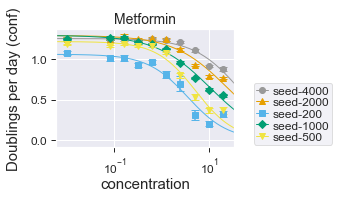

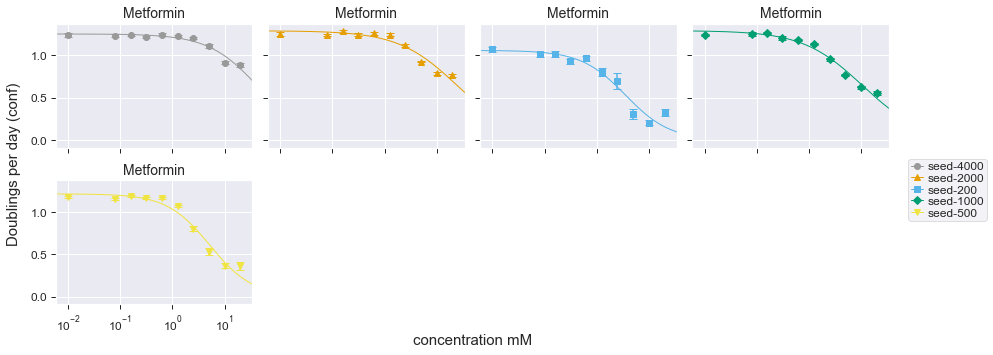

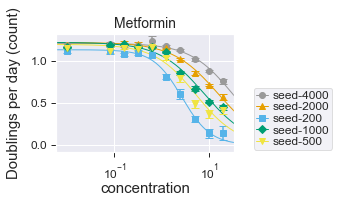

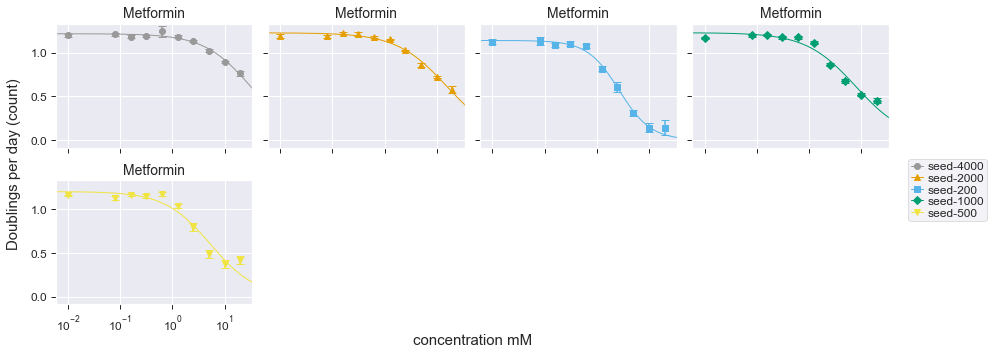

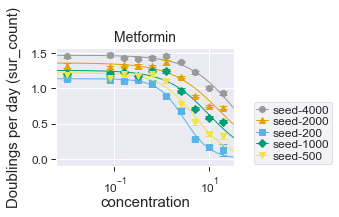

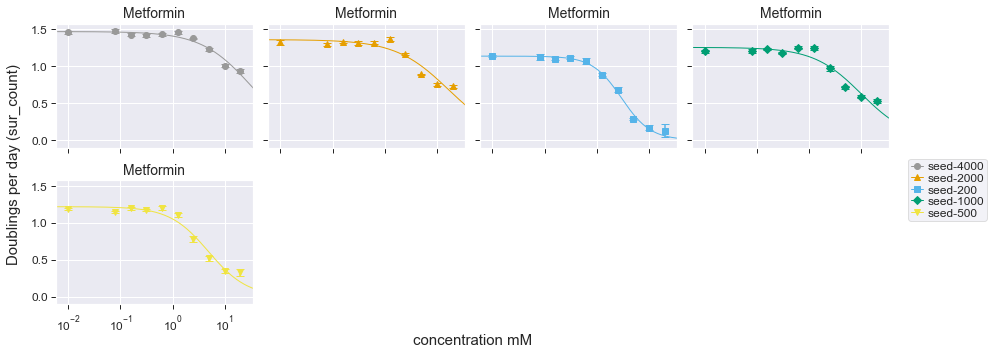

In [14]:
IC50_params_all, plots = calculate_ic50(dpd_df, data_folder, verbose=False)

In [15]:
sns.set_theme(style="ticks")
sns.set_context("talk")

In [16]:
fits = neutcurve.CurveFits(dpd_df[dpd_df['metric']=='count'], conc_col='conc', fracinf_col='dpd', serum_col='gradient_agent', virus_col='single_agent', replicate_col='rep', fixtop=False, fixbottom=0)

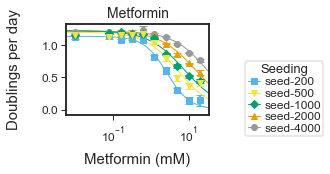

In [17]:
fig, ax = fits.plotSera(xlabel='Metformin (mM)', ylabel='Doublings per day', max_viruses_per_subplot=6, **dict(orderlegend=['seed-200', 'seed-500', 'seed-1000', 'seed-2000', 'seed-4000'], legendtitle='Seeding'))

In [18]:
for el in fig.legends[0].get_texts():
    label = el.get_text()[5:]
    el.set_text(label)
fig.get_axes()[1].set_visible(False)
fig.legends[0].set_title('Seeding')

In [19]:
ax = ax[0][0]
ax.set_xlabel('Metformin (mM)')
ax.set_ylabel('Doublings per day')
ax.set_title('')
ax.grid(True)

In [22]:
fig.tight_layout()
lgd = fig.legends[0]
fig.savefig('H1299_seeding_density_IncuCyte_Metformin.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

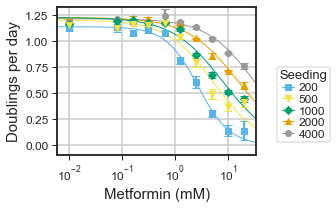

In [23]:
fig

In [41]:
data_file = 'results_flat.xlsx'
df = pd.read_excel(data_file)

In [42]:
# df[df['Seeding'] == 'Dispersed']
fits = neutcurve.CurveFits(df, conc_col='Conc (mM)', fracinf_col='Proliferation rate', serum_col='Drug', virus_col='Seeding', replicate_col='Replicate', fixtop=False, fixbottom=False)

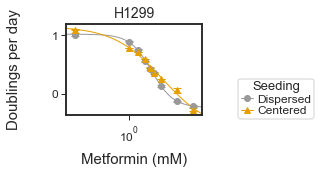

In [43]:
fig, ax = fits.plotSera(titles = ['H1299'], legendtitle='Seeding', xlabel='Metformin (mM)', ylabel='Doublings per day')

In [44]:
fig.get_axes()[1].set_visible(False)

In [45]:
ax = ax[0][0]
ax.set_xlabel('Metformin (mM)')
ax.set_ylabel('Doublings per day')
ax.set_title('')
ax.grid(True)

In [46]:
major_ticks = np.arange(-0.25, 1.25, 0.25)
ax.set_yticks(major_ticks);

In [47]:
fig.tight_layout()
lgd = fig.legends[0]
fig.savefig('H1299_crowding_Metformin.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

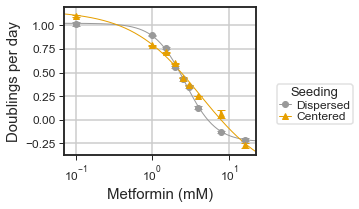

In [48]:
fig